In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0. Cargar dataframe con el corpus

Puede hacer falta instalar *openpyxl*:

`pip3 install openpyxl`

In [2]:
df = pd.read_excel('DATA/corpus2.xlsx')
df.sample(3)

,Unnamed: 0,Exc_register_id,Exc_patientCenter_id,Exc_texto_relleno,TEXTO_SIN_STOPWORDS,texto_tokenizado,Num_palabras,Mexico02,Mexico01,CurrentActivity,...,CSSRS06,CSSRS07,NSSIIS01B_Sometimes,NSSIIS01B_Last_Month_nb,T_WHODAS,T_PHQ_9,T_GAD_2,T_DAST,T_ALC,BMI
698,1875,5daf70582fc6763ec057404a,70230,Me pareció muy interesante la encuesta porque ...,pareció interesante encuesta dan conocer sínto...,"['pareció', 'interesante', 'encuesta', 'dan', ...",10,Si,Si,Estudiante,...,No,NaN,No,0,44.6,12.0,3.0,0.0,0.0,28.303850
799,2035,5e619e188e5df806823be50f,86962,Me obligaron estoy perdiendo el tiempo me hago...,obligaron perdiendo tiempo hago dos horas lleg...,"['obligaron', 'perdiendo', 'tiempo', 'hago', '...",25,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,1426,5da501852fc6763e22324ec0,68189,Muy mal estructuradas las preguntas pues me da...,mal estructuradas preguntas pues dan dos opcio...,"['mal', 'estructuradas', 'preguntas', 'pues', ...",13,Si,Si,Estudiante,...,No,NaN,No,0,65.6,3.0,0.0,0.0,0.0,30.449827


Definimos la columna de texto y de etiqueta

In [3]:
text_col_name = "TEXTO_SIN_STOPWORDS"
label_col_name = "T_GAD_2"

Eliminar las columnas sin etiqueta

In [4]:
df.dropna(subset=[label_col_name],inplace=True)
df.reset_index(drop=True,inplace=True)

Información de las etiquetas de los mensajes

In [5]:

labels = np.unique(df[label_col_name].values)
n_classes = len(labels)
print(f"Hay {n_classes} etiquetas:\n {labels}")

Hay 7 etiquetas:
 [0. 1. 2. 3. 4. 5. 6.]


# 1. Obtener palabras prototípicas

Puede hacer falta instalar *spacy* y el módelo *es_core_news_sm*:

`pip3 install spacy`

`python3 -m spacy download es_core_news_sm`

In [6]:
from SentimentKW import KW

keywords = KW(df,text_col_name=text_col_name, label_col_name=label_col_name)

2022-02-08 12:40:40.696156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-08 12:40:40.696170: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
W0 = keywords.get_kw(topn=100)
list(W0.items())[:10]

[('demasiadas', -0.21070685294285255),
 ('edad', -0.2597963879369219),
 ('parecio', -0.2633835661785657),
 ('resolver', -0.07918441096934463),
 ('momento', -0.24358824692263184),
 ('consecuencias', -0.19796102742336166),
 ('práctica', -0.1580301397071394),
 ('población', 0.0867554186574777),
 ('voy', -0.21211158183308065),
 ('sexuales', -0.11875252950277776)]

# 2. Entrenar modelo de word2vec o FastText

Word2vec:

In [8]:
from gensim.models import Word2Vec

tokens = [x.split() for x in list(df[text_col_name].values)]
print(tokens[:2])

dim = 100
W2V_model = Word2Vec(tokens, min_count=1, vector_size=dim, workers=4, window=5)
W2V_model.save("DATA/w2v-TEXTO_SIN_STOPWORDS.model")

[['persona', 'hipersensible', 'extremadamente', 'emocional', 'asisto', 'terapia', 'dbt', 'dialectical', 'behavor', 'therapy', 'mejorado', 'manera', 'gradual', 'manejo', 'emociones', 'conductas'], ['mantengo', 'relaciones', 'sexuales', 'si', 'puse', 'si', 'estable']]


También se puede entrenar el módelo en FastText

In [8]:
from gensim.models import FastText

dim = 100
FT_model = FastText(tokens, min_count=1, vector_size=dim, workers=4, window=5)

# Genera un archivo más grande
# FT_model.save("DATA/FT-TEXTO_SIN_STOPWORDS.model")   

# 3. Word Scoring

Más información y detalles sobre el uso de esta clase: [https://github.com/labsemco/word-scoring](https://github.com/labsemco/word-scoring)

Leemos el modelo pre-entrenado que vayamos a usar

In [9]:
from scoring import Scoring
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("DATA/w2v-TEXTO_SIN_STOPWORDS.model")

puntaje = Scoring(w2vmodel=w2v_model,W0=W0)

Si es la primera vez que se ejecuta, o se modificaron los embeddings o palabras prototípicas, correr esta celda:

In [11]:
puntaje.build_neighbors(alpha=0.5)

puntaje.save_neighbors("DATA/vecinos-dict.pickle")

Neighbors dictionary saved.


Si no se ha modificado los embeddings o las palabras prototípicas, puede leerse el diccionario de vecinos, para no calcularlo otra vez.

In [10]:
puntaje.load_neighbors("DATA/vecinos-dict.pickle")

Calcular el puntaje de palabras

In [11]:
scores_df = puntaje.transform(df=df,text_col=text_col_name,label_col=label_col_name,beta1=1,beta2=1)
scores_df.sort_values(by='score',ascending=False)

,word,score
955,maestro,0.999997
1382,pánico,0.999993
2282,comunidades,0.999993
2105,pase,0.999993
1877,departamento,0.999993
...,...,...
269,adolescentes,-0.548907
640,ciudad,-0.553531
855,cuadro,-0.585947
462,herramienta,-0.619714


# 4. Clasificación

In [12]:
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
  plt.figure(dpi=120)
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  new_xticks =  [str(int(x.get_text())+1) for x in hmap.xaxis.get_ticklabels()]
  new_yticks =  [str(int(x.get_text())+1) for x in hmap.yaxis.get_ticklabels()]
  hmap.xaxis.set_ticklabels(new_xticks, rotation=0, ha='right')
  hmap.yaxis.set_ticklabels(new_yticks, rotation=0, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## 4.1 Representación de textos usando promedios

Obtenemos una matriz de vectores de features representando a cada entidad de texto. Estas representaciones sirven para realizar la clasificación y predicción de etiquetas, usando métodos de *Machine Learning*.

Hay tres opciones para probar:

* Representación promedio `get_texts_representations_mean()`
* Representación promedio parcial `get_texts_representations_Nmean()`
* Representación PCA `get_texts_representations_PCA()`

In [15]:
# Escoger una de las tres:

# X = puntaje.get_texts_representations_mean()
# X = puntaje.get_texts_representations_Nmean(n=3)
X = puntaje.get_texts_representations_PCA()

X[:3,:5]

array([[ 0.01649833,  0.00087014, -0.04205753,  0.03341715,  0.00188172],
       [ 0.02033583, -0.01294002,  0.01220413, -0.00500742, -0.01063542],
       [ 0.15574715, -0.05531801,  0.01736549, -0.01367876, -0.00178864]])

La clasificación puede hacerse usando cualquier clasificador (k-nearest neighbors, Naive Bayes, xgboost, etc.). La implementación es similar a esta.

Accuracy: 0.3050847457627119
Recall: 0.20608164214302319
ROC: 0.5378762930123784


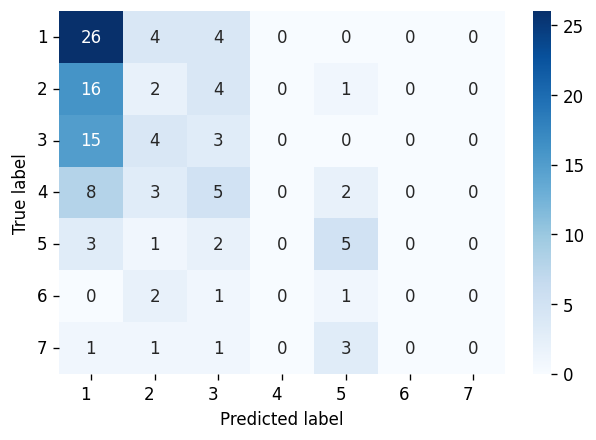

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score,multilabel_confusion_matrix, roc_auc_score,confusion_matrix
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

# Vector de etiquetas
y = df[label_col_name].values

# Entrenamiento y predicción
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=28)
svm = SVC(kernel='rbf', C=1)
svm_model = svm.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)

# Obtenemos las métricas de la clasificación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test,y_pred,average='macro')
roc = roc_auc_score(to_categorical(y_test, n_classes),
                    to_categorical(y_pred, n_classes),
                    multi_class="ovr")
cm = confusion_matrix(y_test,y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"ROC: {roc}")
show_confusion_matrix(cm)


## 4.2 Representaciones usando matrices y CNN

También puede hacerse la clasificación usando una red neuronal convolucional, usando representaciones matriciales de mensajes en lugar de representaciones vectoriales. 

IMPORTANTE: Necesita la tarjeta gráfica, puede correrse en colab.

In [22]:
from sklearn.model_selection import train_test_split

X = puntaje.get_texts_representations_MAT(cols_num=5)  # Puede experimentarse con el valor de cols_num, debe ser mayor o igual que 2.
y = df[label_col_name].values

print("X:",X.shape)
print("y:",y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

val_size = int(0.85*X_train.shape[0])
X_val = X_train[val_size:]
y_val = y_train[val_size:]
X_train = X_train[:val_size]
y_train = y_train[:val_size]
print("Train:",X_train.shape,y_train.shape)
print("Validation:",X_val.shape,y_val.shape)
print("Test:",X_test.shape,y_test.shape)

X: (781, 100, 5)
y: (781,)
Train: (530, 100, 5) (530,)
Validation: (94, 100, 5) (94,)
Test: (157, 100, 5) (157,)


In [23]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

n_classes = len(keywords.labels)

print(f"Las representaciones de los mensajes son de {X_train.shape[0]}x{X_train.shape[1]}")

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', 
                            input_shape=(X_train.shape[1],X_train.shape[2],1)))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# entrenar el modelo:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=16, epochs=200, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

score = model.evaluate(X_test, Y_test)

Las representaciones de los mensajes son de 530x100
Epoch 1/200


2022-02-08 12:20:00.813843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-08 12:20:00.813869: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-08 12:20:00.813883: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skywalker): /proc/driver/nvidia/version does not exist
2022-02-08 12:20:00.814019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


34/34 [==============================] - 0s 7ms/step - loss: 1.7680 - accuracy: 0.2830 - val_loss: 1.6101 - val_accuracy: 0.2979
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 1.6749 - accuracy: 0.2698 - val_loss: 1.6162 - val_accuracy: 0.2872
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 1.5951 - accuracy: 0.3377 - val_loss: 1.5782 - val_accuracy: 0.3404
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 1.5126 - accuracy: 0.3736 - val_loss: 1.5502 - val_accuracy: 0.2660
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 1.4433 - accuracy: 0.4283 - val_loss: 1.5521 - val_accuracy: 0.3723
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 1.3534 - accuracy: 0.4755 - val_loss: 1.5414 - val_accuracy: 0.2979
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 1.3195 - accuracy: 0.5057 - val_loss: 1.6358 - val_accuracy: 0.3298
Epoch 8/200
34/34 [======

Graficamos las curvas de entrenamiento

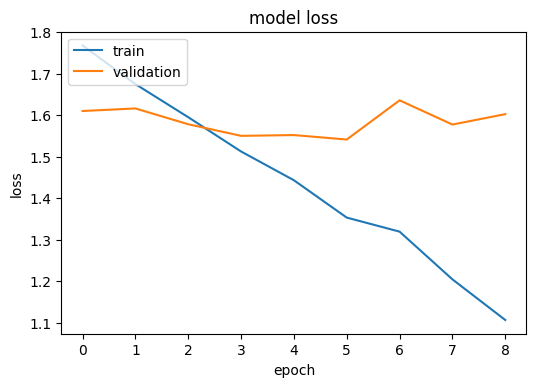

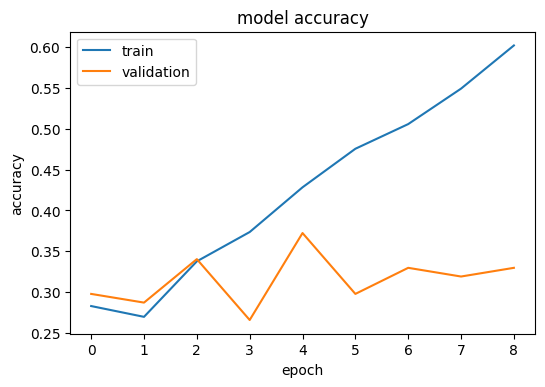

In [24]:
plt.figure(dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=100)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Test loss: 1.785
Test accuracy: 33.12%
ROC: 0.6167171049094762
Accuracy: 0.33121019108280253
Recall: 0.22726328903654483


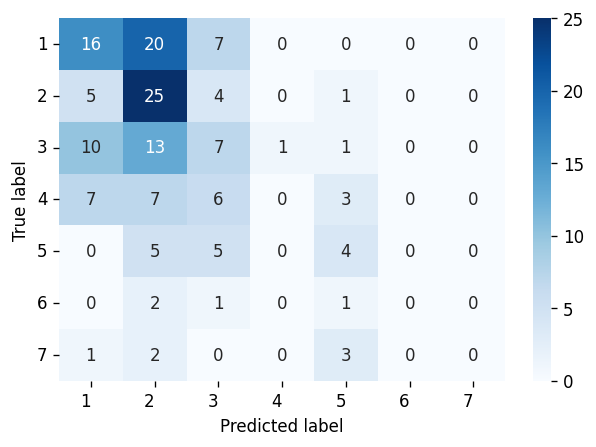

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix
from tensorflow.keras.utils import to_categorical

print (f"Test loss: {round(score[0],3)}")
print (f"Test accuracy: {round(score[1]*100,2)}%")

Y_pred = model.predict(X_test)

roc = roc_auc_score(Y_test,Y_pred,multi_class="ovr")
accuracy = accuracy_score(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
recall = recall_score(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1),average='macro')
cm = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))

print(f"ROC: {roc}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
show_confusion_matrix(cm)